In [ ]:
!git clone https://github.com/arnavj007/cv-project.git temp_repo

!mv temp_repo/requirements.txt .

fatal: destination path '.' already exists and is not an empty directory.
mv: cannot stat 'temp_repo/requirements.txt': No such file or directory


In [ ]:
!pip install -r requirements.txt

In [ ]:
# Import libraries
import os
import ee
import geemap
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from retry import retry

# Create directory for downloaded data
LOCAL_DATA_DIR = './sat_images'
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)


In [ ]:
# Authenticate to Earth Engine (needed for downloading the imagery)
service_account = 'ee-python@cv-project-458123.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, './cv-project-458123-d23a12cd8bfc.json')
ee.Initialize(credentials, project='cv-project-458123', opt_url='https://earthengine-highvolume.googleapis.com')

# Define constants
SCALE = 100
PROJECTION = 'EPSG:32616'
MODEL_BANDS = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'ST_B10', 'elevation']

# Define a map object and display it for ROI selection
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Get ROI from the map
roi = Map.user_roi
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -86.608315,
              39.114079
            ],
            [
              -86.608315,
              39.210975
            ],
            [
              -86.464462,
              39.210975
            ],
            [
              -86.464462,
              39.114079
            ],
            [
              -86.608315,
              39.114079
            ]
          ]
        ]
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

In [ ]:
def mask_clouds(image):
    qa = image.select('QA_PIXEL').bitwiseAnd(int('111111', 2)).eq(0)
    return image.updateMask(qa)


def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)


def calculate_indices(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)


def download_landsat_imagery(roi, output_dir):
    nasadem = ee.Image("NASA/NASADEM_HGT/001")

    landsat_collection = (
        ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
        .filterDate('2023-01-01', '2024-01-01')
        .filterBounds(roi)
        .map(mask_clouds)
        .map(apply_scale_factors)
        .map(calculate_indices)
        .median()
    )

    landsat_imagery = landsat_collection.addBands(nasadem).select(MODEL_BANDS)

    landsat_file = os.path.join(output_dir, "landsat_imagery.tif")
    geemap.ee_export_image(
        landsat_imagery,
        filename=landsat_file,
        scale=SCALE,
        region=roi
    )

    print(f"Landsat imagery downloaded to {landsat_file}")
    return landsat_file


def download_training_data(roi, output_dir):
    """Download training data for the ROI"""
    # Import the training polygons from GeoJSON
    training_polygons = geemap.geojson_to_ee("training_data.geojson")
    training_polygons = training_polygons.filter(ee.Filter.bounds(roi))

    # Filter out specific LCZ classes
    for lcz_class in [1, 4, 7, 10, 16]:
        training_polygons = training_polygons.filter(ee.Filter.neq("LCZ", lcz_class))

    # Convert to image and export
    training_image = training_polygons.reduceToImage(
        properties=["LCZ"], reducer=ee.Reducer.first()
    ).rename('LCZ').toInt()

    training_file = os.path.join(output_dir, "lcz_training.tif")
    geemap.ee_export_image(
        training_image,
        filename=training_file,
        scale=SCALE,
        region=roi
    )

    print(f"Training data downloaded to {training_file}")
    return training_file

# Download data locally
landsat_file = download_landsat_imagery(roi, LOCAL_DATA_DIR)
training_file = download_training_data(roi, LOCAL_DATA_DIR)

Generating URL ...


Please wait ...
Data downloaded to /root/projects/sat_images/landsat_imagery.tif
Landsat imagery downloaded to ./sat_images/landsat_imagery.tif
Generating URL ...
Please wait ...
Data downloaded to /root/projects/sat_images/lcz_training.tif
Training data downloaded to ./sat_images/lcz_training.tif


In [ ]:
def load_and_prepare_data(landsat_file, training_file):
    """Load and prepare data for model training"""
    with rasterio.open(landsat_file) as src:
        landsat_data = src.read()
        landsat_meta = src.meta

    with rasterio.open(training_file) as src:
        training_data = src.read(1)

    # Reshape for model input
    num_bands, height, width = landsat_data.shape
    features = landsat_data.reshape(num_bands, -1).transpose()
    labels = training_data.flatten()

    # Filter valid pixels (both features and labels exist)
    valid_pixels = (~np.isnan(features).any(axis=1)) & (labels > 0)
    X = features[valid_pixels]
    y = labels[valid_pixels]

    print(f"Features shape: {X.shape}, Labels shape: {y.shape}")
    print(f"Unique classes: {np.unique(y)}")

    return X, y, landsat_meta, landsat_data.shape

# Load the data
X, y, landsat_meta, original_shape = load_and_prepare_data(landsat_file, training_file)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

Features shape: (1381, 10), Labels shape: (1381,)
Unique classes: [ 2  3  5  6  8  9 11 12 14 15 17]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class LCZClassifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(LCZClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model and training parameters
input_size = X.shape[1]
num_classes = len(np.unique(y_encoded))

model = LCZClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
for epoch in range(100):
    # Training phase
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/100], '
          f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, '
          f'Val Accuracy: {100 * correct / total:.2f}%')

# Save the trained model
torch.save(model.state_dict(), os.path.join(LOCAL_DATA_DIR, 'lcz_model.pt'))

Epoch [1/100], Train Loss: 2.1437, Val Loss: 1.8990, Val Accuracy: 34.66%
Epoch [2/100], Train Loss: 1.7506, Val Loss: 1.6859, Val Accuracy: 50.54%
Epoch [3/100], Train Loss: 1.6255, Val Loss: 1.6110, Val Accuracy: 47.29%
Epoch [4/100], Train Loss: 1.5626, Val Loss: 1.5413, Val Accuracy: 49.10%
Epoch [5/100], Train Loss: 1.4991, Val Loss: 1.4731, Val Accuracy: 50.90%
Epoch [6/100], Train Loss: 1.4337, Val Loss: 1.4574, Val Accuracy: 53.07%
Epoch [7/100], Train Loss: 1.4130, Val Loss: 1.4201, Val Accuracy: 55.23%
Epoch [8/100], Train Loss: 1.3874, Val Loss: 1.5131, Val Accuracy: 46.57%
Epoch [9/100], Train Loss: 1.3661, Val Loss: 1.3494, Val Accuracy: 51.62%
Epoch [10/100], Train Loss: 1.3226, Val Loss: 1.3938, Val Accuracy: 50.90%
Epoch [11/100], Train Loss: 1.3196, Val Loss: 1.8471, Val Accuracy: 39.35%
Epoch [12/100], Train Loss: 1.3024, Val Loss: 1.8548, Val Accuracy: 27.44%
Epoch [13/100], Train Loss: 1.2508, Val Loss: 2.3060, Val Accuracy: 31.41%
Epoch [14/100], Train Loss: 1.2995

In [ ]:
def predict_on_image(model, landsat_file, output_file, label_encoder):
    """Perform prediction on entire image"""
    with rasterio.open(landsat_file) as src:
        features = src.read()
        meta = src.meta

        # Reshape for model input
        num_bands, height, width = features.shape
        features_reshaped = features.reshape(num_bands, -1).transpose()

        # Filter out no-data values
        valid_pixels = ~np.isnan(features_reshaped).any(axis=1)
        valid_features = features_reshaped[valid_pixels]

        # Run model predictions
        model.eval()
        with torch.no_grad():
            predictions = model(torch.FloatTensor(valid_features))
            _, predicted_classes = torch.max(predictions, 1)

        # Convert from model's encoded labels back to original LCZ class values
        predicted_original_classes = label_encoder.inverse_transform(predicted_classes.numpy())

        result = np.zeros(height * width, dtype=np.uint8)
        result[valid_pixels] = predicted_original_classes
        result = result.reshape(height, width)

        meta.update(
            dtype=rasterio.uint8,
            count=1,
            nodata=0
        )

        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(result, 1)

    return output_file, result

output_file = os.path.join(LOCAL_DATA_DIR, "lcz_classification.tif")
prediction_file, prediction_data = predict_on_image(model, landsat_file, output_file, label_encoder)

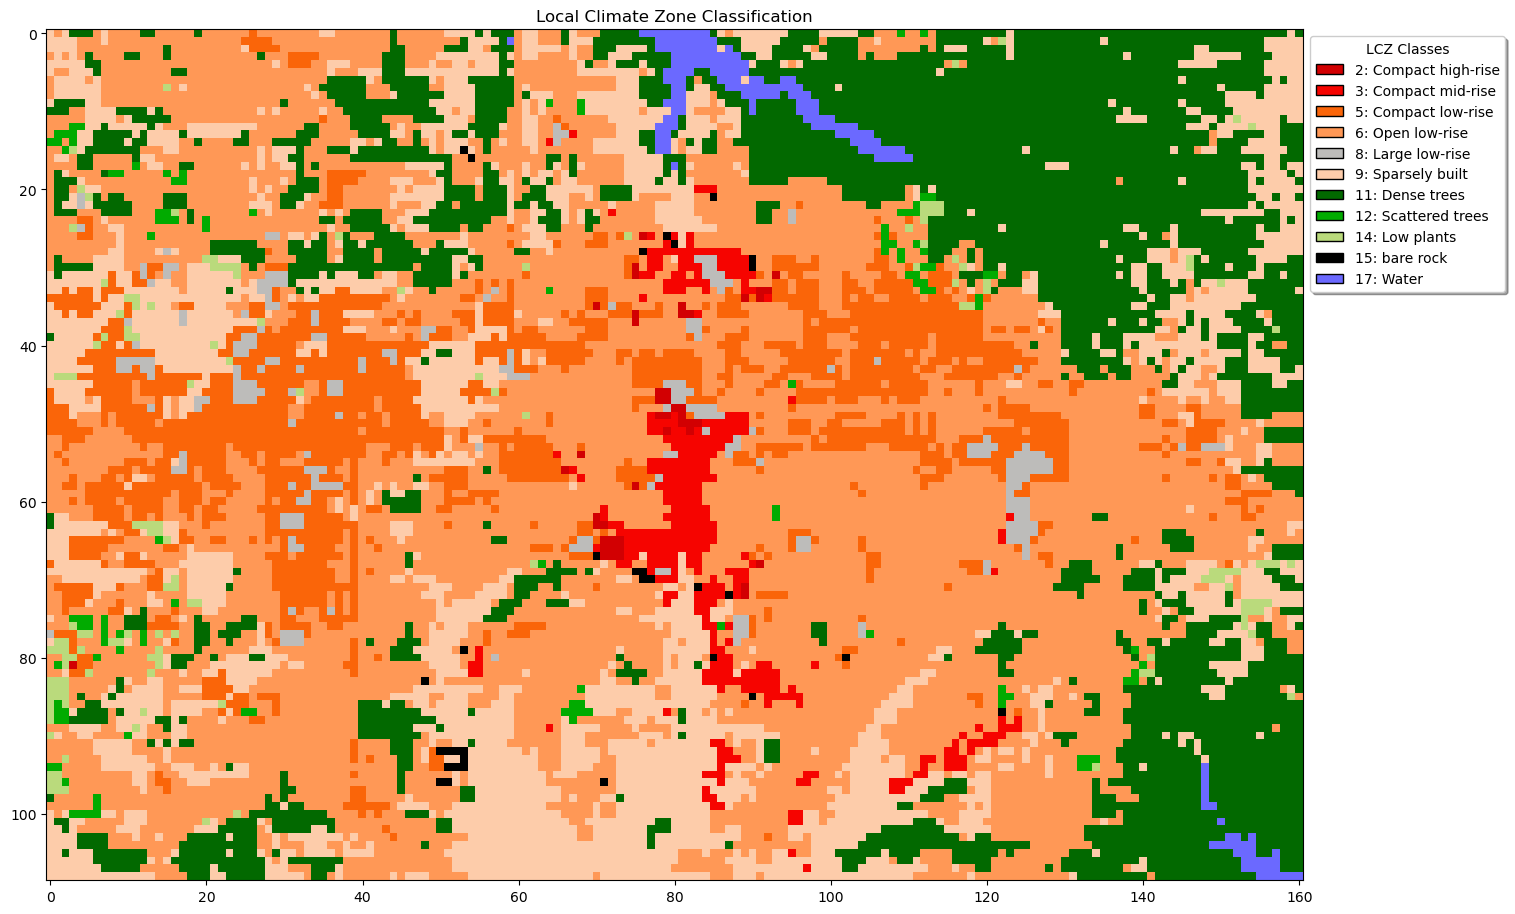

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

with rasterio.open("./sat_images/lcz_classification.tif") as src:
    classification_data = src.read(1)
    unique_classes = np.unique(classification_data)

lcz_colors = {
    # 1: "#8b0204",
    2: "#d20002",
    3: "#f60400",
    # 4: "#c34d01",
    5: "#fa6509",
    6: "#ff9856",
    # 7: "#fdee00",
    8: "#bdbcba",
    9: "#fdccaa",
    # 10: "#545356",
    11: "#026900",
    12: "#01ab00",
    # 13: "#628622",
    14: "#bada7c",
    15: "#000100",
    # 16: "#fdf7ad",
    17: "#6b69ff"
}

lcz_names = {
    2: 'Compact high-rise',
    3: 'Compact mid-rise',
    5: 'Compact low-rise',
    6: 'Open low-rise',
    8: 'Large low-rise',
    9: 'Sparsely built',
    11: 'Dense trees',
    12: 'Scattered trees',
    14: 'Low plants',
    15: 'bare rock',
    17: 'Water'
}

cmap = ListedColormap([lcz_colors[cls] for cls in unique_classes])
norm = BoundaryNorm(boundaries=[cls - 0.5 for cls in unique_classes] + [unique_classes[-1] + 0.5], ncolors=len(unique_classes))
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(classification_data, cmap=cmap, norm=norm)

legend_elements = []
for cls in unique_classes:
    if cls in lcz_colors and cls in lcz_names:
        legend_elements.append(
            Patch(facecolor=lcz_colors[cls],
                  edgecolor='black',
                  label=f"{cls}: {lcz_names[cls]}")
        )

ax.legend(handles=legend_elements,
          loc='upper left',
          bbox_to_anchor=(1, 1),
          title='LCZ Classes',
          frameon=True,
          fancybox=True,
          shadow=True)

plt.title('Local Climate Zone Classification')
plt.tight_layout()
plt.show()